This notebook was prepared by:

Jack Brennen (jpb9088@nyu.edu)

Fabrizio Cabrera (fc2250@nyu.edu)

Alex Ferrante (af3913@nyu.edu)

Graduate School of Arts and Sciences (GSAS) at New York University (NYU)

May 2022

# One Day Ahead Movement Stock Prediction - Application of Machine Learning Binary Classifiers  

In the stock market shares of firms are traded. Trading is an important feature of the economy because it gives firms access to capital in exchange for a share of ownership. Speculation in stock prices means that traders buy when they think prices are going up and sell when they think prices are going down. This would be profitable for traders making accurate predictions of stock prices. However, the predictability of stock prices has been questioned.

According to the efficient market hypothesis (EMH) the stock market follows a random walk and is inherently unpredictable (Sargent, 1986). The EMH implies that all information available today is reflected in prices of stocks today and the changes in tomorrows price will only depend on the news of tomorrow. This is because that the stock market is perceived to be very informationally efficient and comopetitive. Since we cannot predict news, stock forecasting is impossible. This would have the consequence that prices are fairly priced and one can not beat the market using current information. Burton Malkiel claims that a strong argument for the market being efficient and unpredictable is that fact that expert investors are unable to beat the market (Malkiel, 2003).

The ability to predict the movement of a stock was once far fetched, however, thanks to advancements in machine learning techniques, there is reason to believe short-run predictions are possible, within reason. So what makes stock movement prediction tricky? Well, several factors, but one which is most obscure is market noise. With most persons' having access to the internet, news spreads quickly. This means consumers' sentiments are subject to changing quickly, resulting in short-run market fluctuations. Exogenous shocks to the market come in many forms and all of which are reported on. With the rise of internet news platforms these sources server as venues for market particpants to consume stock information which subsequetly informs short-run behavior. 

Since we believe that capturing trends in agents news consumption is valuable in explaining short-run movements in stocks, this project will include data from Google Trends and Wikipedia API's to serve as indexes to inform the frequency and popularity of stock news. In addition to data collected from Google Trends and Wikipedia API's we also collect general stock data (open, close, volumem ect.). Through the use of random forrests, convolutional neural networks (CNN), and recursive neural networks (RNN) we will contruct a binary-classification task and see how accurately we can model short-run stock movement. While there are an array of targets we could test, the target for the procedding models will be whether the stock closing price will increase tomorrow (1) or whether it will decrease (0). 

Given constraints in time and computing power, we will collect data from 01/01/2019 to 03/31/2022 for Ford, Netflix, and UBS. The stocks selected cover three different industires which will allow us to tests our models preictive power in varying markets.   


## 1. Pulling Together the Data

As the saying goes, garbage in, garbage out. Thus, we gave some serious thought on how to best collect our data. This section reviews the necessary steps taken to aquire the stock and news data from their respective API's and the subsequent data cleaning procedures. Given that the web scraping process was computationally expensive, this section will display the code in its raw form. At the end of section two the cleaned and transformed CSV data files will be made available. Your computer will thank us later.

In [14]:
# Import the necessary data cleaning packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

#%pip install pytrends
import pytrends
from pytrends.request import TrendReq
#%pip install pageviewapi
import pageviewapi
#%pip install yfinance
import yfinance as yf

# Import machine learning packages
import tensorflow as tf
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, SimpleRNN, LSTM, TimeDistributed, BatchNormalization, Conv1D, MaxPooling1D, Flatten, InputLayer
from sklearn.model_selection import TimeSeriesSplit
from keras.regularizers import l1, l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import keras_tuner as kt

Below is the function used to web scrape the data from Yahoo Finance, Google Trends, and Wikipedia. We will walk through the data collection process and will provide an example using Ford. Note, Netflix and UBS followed an identical processes. 

In [ ]:
def Big_scraper(kw_list_1, kw_list_2, ticker, start,end):
    
    """
    Description:
    ------------
    
    The function initially grabs historical, indexed, hourly data for when the keyword 
    was searched most as shown on Google Trends' Interest Over Time section.
    It then cleans the data to show daily hits on the keyword in Google news.

    
    input:
    -----
    kw_list_1: List of up to 5 key words that will be scraped from google trends for the dates given.
             Here, the scraping will pull the total posted items in google news that contains
             one of the key words.
    
    kw_list_2: List of wikipedia article titles (unlimited length) that will pull the amount of
            views the article recieved each day. 

    ticker: the ticker abriviation of the desired stock. Must be netered in as an all capitalized string 
    example Apple Inc. woud be "AAPL"
             
    start: the start of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
    
    end: the end of the desired timeline you want scrape. Date Must be entered in as "YYYYMMDD"
             
    return:
    -------
    
    combined: a dataframe containing the sum of the daily keyword hits in google news (key words labeled _x),
    
    data frame cointaing stock info including open, close, high, low prices of the stock,
    as well as the stocks daily trading volume and the amount if there was a split or dividend 
    preformed on the stock that day,
    
    and the sum of how many times key word wikipedia pages were viewed in a day (key words labeled _y)
    """
    
    year_s = int(start[0:4])
    month_s = int(start[4:6])
    day_s = int(start[6:8])
    year_e = int(end[0:4])
    month_e = int(end[4:6])
    day_e = int(end[6:8])
    
    starter = pd.to_datetime(f"'{year_s}-{month_s}-{day_s}'")
    ender = pd.to_datetime(f"'{year_e}-{month_e}-{day_e}'")
    
    
    pytrends = TrendReq(hl='en-US', tz=360, retries=10)
    jeff = pytrends.get_historical_interest(kw_list_1, \
                                 year_start = year_s, month_start = month_s, day_start = day_s, hour_start = 1, \
                                 year_end = year_e, month_end = month_e, day_end = day_e, hour_end = 23, \
                                 cat = 0, geo = '', gprop = 'news', sleep = 60)
    
    jeff = jeff.iloc[:, 0:-1] # eliminates the isPartial Column
    jeff = jeff.reset_index().drop_duplicates(subset = "date") #removing duplicates from the index
    jeff = jeff.groupby(pd.Grouper(key="date", freq="D")).mean() # coverts to the mean of daily scores

    dow = yf.Ticker("^DJI")
    dow_h = dow.history(start=starter, end=ender)
    dow_h = pd.DataFrame(dow_h)
    dow_names = {"Open":"dow_open","Close":"dow_close","Low": "dow_low",
    'High':'dow_high','Volume':'dow_vol'}
    dow_h=dow_h.rename(dow_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    nas = yf.Ticker("^IXIC")
    nas_h = nas.history(start=starter, end=ender)
    nas_h = pd.DataFrame(nas_h)
    nas_names = {"Open":"nas_open", "Close":"nas_close", "Low": "nas_low",
    'High':'nas_high','Volume':'nas_vol'}
    nas_h=nas_h.rename(nas_names, axis=1).drop(["Dividends","Stock Splits"], axis=1)

    market = dow_h.merge(nas_h,left_index=True, right_index=True, how="left")
    
    tick = yf.Ticker(ticker)
    hist = tick.history(start=starter, end=ender)
    hist = pd.DataFrame(hist)
    
    combined = jeff.merge(hist, left_index=True, right_index=True, how="left")
    combined = combined.merge(market, left_index=True, right_index=True, how="left")  
    
    d = pd.DataFrame()
    for key_word in kw_list_2:
        geoff = pageviewapi.per_article('en.wikipedia', key_word, start, end,
                                    access='all-access', agent='all-agents', granularity='daily')
        dicty = dict(geoff)
        views = pd.DataFrame(dicty["items"])
        views["timestamp"] = pd.to_datetime((views["timestamp"]), format="%Y%m%d%H")
        views = views.set_index("timestamp")
        page = pd.Series(views["views"])
        d[key_word] = page
        
    combined = combined.merge(d, left_index=True, right_index=True, how="left") 
    
    return combined

When it comes to collecting data on daily stock performance indicators (i.e Open, close, volume, ect.) the Yahoo Finance API works wonders. With respect to our decision to incorporate news data, the task becomes a little more involved. Within the funtion above you will notice the kw_list_1 and kw_list_2 parameters. These are necessary requisits for the Google News and Wikipedia API's. The keywords selected in kw_list_1 were arbitrarily determined, but choosen in the context of capturing relevant stock news. The keywords in kw_list_2 were also a bit arbitrary, however, in order for the Wikipedia API to work, the list of strings must correspond to exisiting Wikipedia webpages. Below are the keywords lists implemented for Ford. 

In [ ]:
kw_list_1 = ["Ford", "F-150", "Ford Bronco", "Ford Mustang", "Ford Stock"]
kw_list_2 = ["Ford Motor Company", "Ford Mustang", "Ford F Series", "Ford Bronco", "Lincoln Navigator", "Lincoln Aviator", "Ford GT"]

Once the key words were determined, we then implemented the big_scraper function and web scraped data for the specified time-frames. The scraper was ran four times, creating seperate data files for each year.

In [ ]:
# Concatenate each of the annual datafiles to create one main
Ford_19 = Big_scraper(kw_list_1, kw_list_2,"F", "20190101", "20191231")
Ford_20 = Big_scraper(kw_list_1, kw_list_2,"F", "20200101", "20201231")
Ford_21 = Big_scraper(kw_list_1, kw_list_2,"F", "20210101", "20211231")
Ford_22 = Big_scraper(kw_list_1, kw_list_2,"F", "20220101", "20220331")

ford = pd.concat([Ford_19, Ford_20, Ford_21, Ford_22])

Since stocks are traded only during weekdays and news data is reported daily, we decided to drop data collected for weekends and holidays. While this reduces the number of news observations, it was a step taken to reduce the amont of NaN values in our data.  

In [ ]:
#converting the date column back to datetime 
Ford.date = pd.to_datetime(Ford.date)

from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# create dateframe 2019-01-01 to 2022-03-31 which excludes weekends and holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
dates = pd.date_range(start='2019-01-01', end='2022-03-31', freq=us_bd)
dates = pd.DataFrame(dates)
dates = dates.rename(columns={0: "date"})

# Merge on new date range to remove weekends and holidays in ford dataset
Ford = dates.merge(Ford, on="date", how="left")
Ford = Ford.set_index("date")
Ford.head()

### 2. Data Processing - Feature and Target Creation

In this next phase of data processing we focus on using the existing data pulled to generate additional features and targets. From the Google News and Wikipedia data collected, we sum across each of the keyword list results to create two new features noted as "Wiki_total" and "Google_total", respectively. These new "total" features will then be used as denominator values and assist in creating more features which with the hope of providing greater explanantory power to our future models.   

In [ ]:
# creating base varibles to be used in variable creator functions
Ford["Wiki_total"] = (Ford["Ford Motor Company"] + 
    Ford["Ford Mustang_y"] + Ford["Ford F Series"] + 
    Ford["Ford Bronco_y"] + Ford["Lincoln Navigator"] + 
    Ford["Lincoln Aviator"] + Ford["Ford GT"])

Ford["Google_total"] = (Ford["Ford"] +
    Ford["F-150"] + Ford["Ford Bronco_x"] +
    Ford["Ford Mustang_x"] + Ford["Ford Stock"])

Ford["Stock_total"] = Ford["Close"]
Ford["Nas_total"] = Ford["nas_close"]
Ford["Dow_total"] = Ford["dow_close"]

In [ ]:
def variables_creator(df, variable_list, w=7):
    
    '''
    descrition:
    -----------
    takes dataframe and returns new varibles based on recommmended calcualtions, 
    it should be done seporately with internet based and stock based dataframes

    Note: When using for aggreated varaibles, for example Wiki_total, the sum of all the wiki pages daily page view counts, 
    you MUST calculate Wiki_total in the dataframe seperately BEFORE this function can be used. 

    For example if you had wiki page counts for Ford Bronco and Ford Ranger, Wiki_total would equal Ford Bronco + Ford ranger counts, 
    AGAIN Wiki_total must be calculated in the desired dateframe before using this function 

    input:
    ------
    df: dataframe containing the google trends, yahoo finance, and or wikipedia page count data

    variable_list: list of strings to be added to the equations to calculate the new varaibles. 
    ex. insertting the string "Wiki" will add to df[f"{}_total"] to become "Wiki_total"

    w: the window length for one period shift. Default is 7 providing 7 day moving averages for wiki and google data, 
        FOR STOCK DATA THIS WILL NEED TO BE CHANGED TO 5.

    output:
    -------
    df: the same dataframe as was inputted but now containing variables for 
    Momemtum, Disparity, Moving Average, Exponential Moving Aerage, Rator Change, and RSI index score.
    Also containg are moving variables, which are boolean with 1 indicating an increase in the above variables
    '''   
    
    for i in variable_list:
        # Momentum_1
        df[f"{i}_Moment_1"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(w)) * 100
        # Momentum_2
        df[f"{i}_Moment_2"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(w)) * 100
        # Momentum_1_s three day shift (instead of w)
        df[f"{i}_Moment_1_s"] =  (df[f"{i}_total"] / df[f"{i}_total"].shift(3)) * 100
        # Momentum_2_s
        df[f"{i}_Moment_2_s"] =  (df[f"{i}_total"] - df[f"{i}_total"].shift(3)) * 100
        # Moving average
        df[f"{i}_MAvg"] = df[f"{i}_total"].rolling(f"{w}d").mean()
        # Moving average 3 day
        df[f"{i}_MAvg_s"] = df[f"{i}_total"].rolling("3d").mean()
        # Disparity
        df[f"{i}_Disparity"] = (df[f"{i}_total"]/df[f"{i}_MAvg"]) * 100
        # Disparity 3 day
        df[f"{i}_Disparity_s"] = (df[f"{i}_total"]/df[f"{i}_MAvg_s"]) * 100
        # Rate of Change Normal Way
        df[f"{i}_ROC"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(w))/(df[f"{i}_total"].shift(w)) *100
        df[f"{i}_ROC_s"] = (df[f"{i}_total"]-df[f"{i}_total"].shift(3))/(df[f"{i}_total"].shift(3)) *100
        #Rate of Change Paper Way (doesn't make sense but just in case)
        df[f'{i}_Rocp'] = (df[f"{i}_total"]/df[f"{i}_Moment_2"]) *100
        # Exponential Moving Average
        df[f"{i}_EMA"] = (df[f"{i}_total"]-df[f"{i}_MAvg"].shift(1))*(2/(w+1))+df[f"{i}_MAvg"].shift(1)

        # calculating the Relative Strength Index, based on 14 day window
        df[f"{i}_diff"] = df[f"{i}_total"].diff(1)
        df[f"{i}_gain"] = df[f"{i}_diff"].clip(lower=0).round(2) #keeps all values above or below a given threshold, lower=lower bound
        df[f"{i}_loss"] = df[f"{i}_diff"].clip(upper=0).round(2)
        df[f'{i}_avg_gain'] = df[f'{i}_gain'].rolling(14).mean()
        df[f'{i}_avg_loss'] = df[f'{i}_loss'].rolling(14).mean()
        df[f'{i}_rs'] = df[f'{i}_avg_gain'] / df[f'{i}_avg_loss']
        df[f'{i}_RSI'] = 100 - (100 / (1.0 + df[f'{i}_rs']))

        # Calculatiing the Move Variables 
        df[f"{i}_Move"] = df[f"{i}_total"] > df[f"{i}_total"].shift(1) 
        df[f"{i}_Move"] = df[f"{i}_Move"].replace({True:1,False: 0})
    
      
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg"] > df[f"{i}_MAvg"].shift(1) 
        df[f"{i}_MAvg_Move"] = df[f"{i}_MAvg_Move"].replace({True:1,False: 0})
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s"] > df[f"{i}_MAvg_s"].shift(1) 
        df[f"{i}_MAvg_s_Move"] = df[f"{i}_MAvg_s_Move"].replace({True:1,False: 0})

        df[f"{i}_EMA_Move"] = df[f"{i}_EMA"] > df[f"{i}_EMA"].shift(1) 
        df[f"{i}_EMA_Move"] = df[f"{i}_EMA_Move"].replace({True:1,False: 0})

        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity"] > df[f"{i}_Disparity"].shift(1) 
        df[f"{i}_Disparity_Move"] = df[f"{i}_Disparity_Move"].replace({True:1,False: 0})
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s"] > df[f"{i}_Disparity_s"].shift(1) 
        df[f"{i}_Disparity_s_Move"] = df[f"{i}_Disparity_s_Move"].replace({True:1,False: 0})

        df[f"{i}_RSI_Move"] = df[f"{i}_RSI"] > df[f"{i}_RSI"].shift(1) 
        df[f"{i}_RSI_Move"] = df[f"{i}_RSI_Move"].replace({True:1,False: 0})
        
    return df

In [ ]:
Ford = variables_creator(Ford, ["Wiki","Google", "Stock", "Nas", "Dow"], 5)

Now that we have a comprehesive feature matrix of data, we turn to generating the targets. As mentioned, there are a variety of targets that could be tested to predict stock movement. Below we have generated five binary targets, each either related to the stock close price, open price, or volumne. For the purposes of the models developed in this project, we will focus on trying to accurately predict "target_3" - the difference in closing price. This target's result is binary where an increase in the closing price returns a value of 1 and a decrease in the closing price returns 0.

In [ ]:
def target_creator(df):
    '''
    description: creates the differnt types of target variables based on tomorrow minus today,
    '''
        
    # target 1, Open(t+1) - Close(t)
    df["target_1"] = (df["Open"].shift(-1) - df["Close"]) > 0
    df["target_1"] = df["target_1"].replace({True:1,False: 0})
    # target 2
    df["target_2"] = (df["Open"].shift(-1) - df["Open"]) > 0
    df["target_2"] = df["target_2"].replace({True:1,False: 0})
    # target 3
    df["target_3"] = (df["Close"].shift(-1) - df["Close"]) > 0
    df["target_3"] = df["target_3"].replace({True:1,False: 0})
    # target 4
    df["target_4"] = (df["Close"].shift(-1) - df["Open"]) > 0
    df["target_4"] = df["target_4"].replace({True:1,False: 0})
    # target 5
    df["target_5"] = (df["Volume"].shift(-1) - df["Volume"]) > 0
    df["target_5"] = df["target_5"].replace({True:1,False: 0})
 
    return df

Ford = target_creator(Ford)

Finally, we've made it to a stage where out data set includes many features and targets to test them on. 

Below are the fully cleaned and model ready CSV files for Ford, Netflix, and UBS.

In [3]:
# Import Ford, Neflix, and UBS data 

Ford = pd.read_csv("Ford_Cleaned_Date.csv",
                  parse_dates=True,
                  infer_datetime_format=True,
                  index_col="date")

netflix = pd.read_csv("netflix_model_ready.csv",
                      parse_dates=True,
                      infer_datetime_format=True,
                      index_col="date")

ubs = pd.read_csv("UBS_Cleaned_Date.csv",
                 parse_dates=True,
                 infer_datetime_format=True,
                 index_col="date")

### 3. Feature Selection 

Now that we have the data cleaned, additional features created, and targets set, we can begin to think about constucting our models. However, before jumping into deciding which model to use and the appropriate architecture for this time-series, binary classfication task, we must first give some thought to what features are going to give our models the greatest preictive power.

Taking a look first at the shape of our data, we notice that there are quite a few features present.

In [180]:
# Print shape of Ford data 
print("There are {} observations and {} features".format(Ford.shape[0], Ford.shape[1]))

There are 815 observations and 169 features


With 169 features in total, it is likely the case that not all variable are valuable in predicting our target. A generic, although not often recommended approach would be the kitchen sink, where all 169 features would be included in our models. While this would be simple, if we work under the assumption that some variables are not relevant in explaining our target, then this approach would negatively affect our models ability to learn since we would be introducing unnecessary noise. While there are many approaches to feature selection, we decide on the implement the following strategies:

1) SelectKBest

2) Principal Component Analysis

3) Blended - Identify the "best features" through SelectKBest, then run a PCA on those features

From the Keras "feature_selection" library, the SelectKBest function works by implementing an f-regression to identify the N number of features that have the greatest significance in explaining the identified target.  

Let's continue with using Ford as an example and see how these feature selection methodologies are implemented.

We'll first do a little more data manipulation.

In [4]:
# SelectKBest implementation

# to remove first 14 days that include NaNs due to some calculations
Ford = Ford.iloc[14:, :] 

# to remove duplicated columns
Ford = Ford.drop(["Nas_total", 'Stock_total', 'Dow_total'],axis=1) 

Ford_0 = Ford.dropna()
Ford_0 = Ford_0[~(Ford_0.isin([np.inf, -np.inf]).any(axis=1))] 

# Drop additional targets
Ford_0 = Ford_0.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

# Target will be 3 (close to close)
target_3_0 = Ford_0["target_3"]

# Print shape 
print(Ford_0.shape, target_3_0.shape)

# Standardize the data 
Mscaler = MinMaxScaler()
Ford_0 = pd.DataFrame(Mscaler.fit_transform(Ford_0), columns = Ford_0.columns)

# Implement SelectKBest class to extract 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=40)
best_fit = bestfeatures.fit(Ford_0, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford_0.columns)

# concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
print(features_score.nlargest(40, 'Score'))  


(709, 162) (709,)
                   Features         Score
161                target_3  1.675813e+17
105          Stock_EMA_Move  3.460924e+00
125            Nas_avg_loss  3.262932e+00
4                Ford Stock  2.887783e+00
107  Stock_Disparity_s_Move  2.847750e+00
152                  Dow_rs  2.302643e+00
54      Wiki_Disparity_Move  2.212012e+00
103         Stock_MAvg_Move  2.207490e+00
151            Dow_avg_loss  2.078600e+00
91                Stock_ROC  1.979319e+00
83           Stock_Moment_1  1.979319e+00
51           Wiki_MAvg_Move  1.953221e+00
99           Stock_avg_loss  1.892805e+00
84           Stock_Moment_2  1.720291e+00
128                Nas_Move  1.711026e+00
65               Google_ROC  1.707825e+00
57          Google_Moment_1  1.707825e+00
49                 Wiki_RSI  1.693034e+00
96               Stock_gain  1.597459e+00
145                Dow_Rocp  1.469532e+00
104       Stock_MAvg_s_Move  1.460520e+00
8                     Close  1.422680e+00
6               

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Shown above the top 40 features (descending order) that have the greatest significance with respect to target 3. This list can now give us greater insight into which features should be included in model testing and which should be dropped.

Alternatively, we could use a PCA approach to reduce the dimenstionality of the data without having to necessarily hand pick features. Let's see this in action.

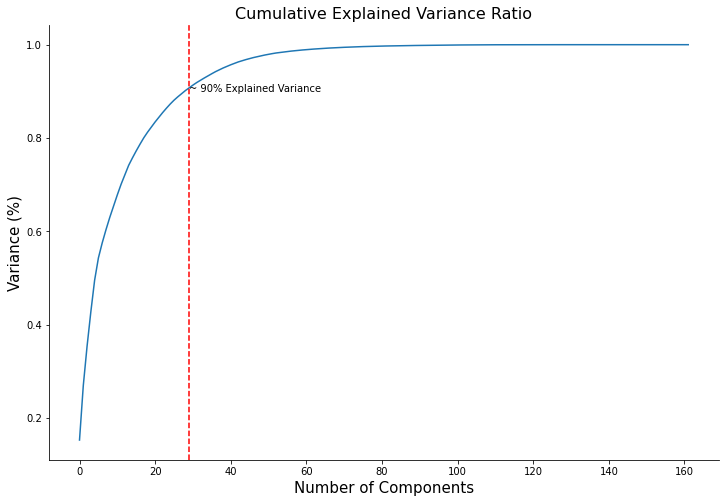

[ 15.31107174  26.97356724  35.4158046   42.8039859   49.56347884
  54.32643416  57.52773904  60.36003731  62.99532704  65.43458547
  67.82910224  70.1041639   72.16151327  74.15746023  75.74478932
  77.25280616  78.68520942  80.05502218  81.25627283  82.36456728
  83.44883405  84.46545182  85.46627417  86.4034451   87.29597109
  88.11190775  88.83198647  89.50943912  90.1678721   90.76544485
  91.34184936  91.88739678  92.38234018  92.86520706  93.33285019
  93.78859523  94.23467756  94.63323099  95.01318674  95.36270847
  95.69626479  96.01170645  96.30888682  96.56420145  96.80475474
  97.03328609  97.23941988  97.42897703  97.61554051  97.78427353
  97.93944351  98.08818003  98.22313548  98.33031171  98.43416827
  98.53328939  98.6288264   98.7133186   98.79275952  98.86910748
  98.93941168  99.00341745  99.0648662   99.12138947  99.17505735
  99.22818871  99.27753475  99.32174712  99.36306824  99.40151556
  99.43852772  99.47325582  99.50642342  99.53803014  99.56646037
  99.59306

In [5]:
# PCA implementation
pca = PCA().fit(Ford_0)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 29
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.9))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 


From the graph depicted above, we can apply a PCA decomposition on our origional feature data and with using only 29 principal components explain approximately ~90% of the variance of our target.

In the third and final approach mentioned, we look to blend the two feature selection strategies by running a PCA decomposition, but only on the N best features found using SelectKbest. The rationale behind this blended strategy is that if we look at the bottom half of the SelectKBest results (presented above), we notice that many of the features are marginally significant in explaining the target. It could be the case that including features which have little explanitory power is causing more harm than good. Mainly, thier inclusion could introduce more noise than predicitve power. Thus, by only selecting features which have a relitively stronger and significant relationship to the target we can have greater confidence that we are mitigating the inculsion of noisy features.

In [6]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(Ford_0, target_3_0)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford_0.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Keep only the top 40 features
Ford_best = Ford_0[feats_kb]

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


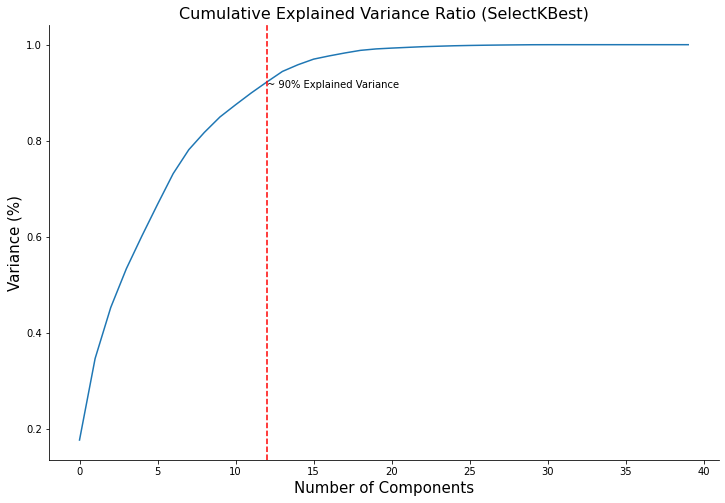

[ 17.70747223  34.68033139  45.29003853  53.36039847  60.20281895
  66.77182757  73.15808383  78.13339596  81.74622545  84.96194723
  87.49526292  89.946743    92.22990157  94.43213885  95.83029608
  96.99276953  97.66773605  98.27514108  98.82005779  99.11936491
  99.28992001  99.43904401  99.58304976  99.68102714  99.7744482
  99.83968806  99.89126222  99.92826366  99.95974658  99.98931676
  99.99630461  99.998119    99.99887178  99.99930094  99.99962716
  99.99987783 100.         100.         100.         100.        ]


In [184]:
# PCA implementation
pca = PCA().fit(Ford_best)
fig, ax = plt.subplots(figsize=(12,8))

# Display cumulated explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance Ratio (SelectKBest)', fontsize=16)
plt.xlabel('Number of Components', fontsize=(15))
plt.ylabel('Variance (%)', fontsize=(15)) 

annotation = 12
plt.axvline(annotation, color='r', linestyle='--')
plt.annotate('~ 90% Explained Variance', xy=(annotation, 0.8), xytext=(annotation, 0.91))

ax.spines[['top', 'right']].set_visible(False)

plt.show()

print(np.cumsum(pca.explained_variance_ratio_) * 100) 

When using a PCA transform on the features found from SelectKBest, it is possible to explain ~90% of the variance with far fewer principal components. 

### 4. Model Development and Testing

In the previous section we reviewed a few of the possible feature selection techniques used by machine learning practitioners. In this section we will dive into model development and testing, where we begin to see the fruits of our computers labor. One thing to note is that each of the three algorthms presented (Random Forest, CNN'S, and RNN's) were tested using each of the feature selection methodologies. We felt that this approach would allow us to be comprehesive in finding optimal results, while also added an experimetnal element to model development. That being said, trialing feature selection approaches resulted in many models being created. In an effort to reduce unnecesary confusion, we will only present the models which generated the best results and the processes undertaken to arrive at them. Additionally, the following section will only present the code used in the development of Fords models. Results for Netlifx and UBS will be presented, however, for brevity the code will not be included. Additional code can be found on the project GitHub repository (https://github.com/fabcabrera/Stock-Predictions). 

#### 4.1 Random Forest

Random forest uses several decision trees and takes the mean output of all the trees as the result. Each tree is trained randomly on a subset of the input data. Doing this removes the issue of over-training and allows for more features for a smaller performance cost (Kam Ho, 1995). 
Decision trees are flowcharts that depict outcome probabilities depending on given variables. The problem of creating such trees optimally is nondeterministic-polynomial-time complete (Hyafil, 1976) but approximate methods do exist. For example, induction of decision is a common method. With this method the set of input is divided based on some output value being above a threshold that is random. Then an input variable is chosen and a threshold set so that as many values are classified correctly as possible. This process continues recursively until all the data is classified in a correct way, or no improvement can be made (Ross Quinlan, 1986).

The following code will work through the steps taken to build our random forest. 

In [7]:
# Drop NaNs
Ford = Ford.dropna()
Ford = Ford[~(Ford.isin([np.inf, -np.inf]).any(axis=1))] 

# Generate target vector and feature matirx 
target_3 = Ford["target_3"]
Ford = Ford.drop(['target_1', 'target_2', 'target_4', 'target_5'], axis=1)

# Split into training and testing sets 
column_indices = {name: i for i, name in enumerate(Ford.columns)}

n = len(Ford)

X_train = Ford[0:int(n*0.9)]
X_test = Ford[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [8]:
# Print distirbution of target variable
counts = y_train.groupby(by = y_train).count()
counts = pd.Series(counts)
print(counts)

target_3
0    330
1    308
Name: target_3, dtype: int64


In [9]:
# Standardize the data
Mscaler = MinMaxScaler() 

X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = Ford.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = Ford.columns)

In [10]:
# Apply SelectKBest class to extract top 40 best features
bestfeatures = SelectKBest(score_func=f_regression, k=41)
best_fit = bestfeatures.fit(X_train, y_train)
best_scores = pd.DataFrame(best_fit.scores_)
best_columns = pd.DataFrame(Ford.columns)

# Concatenate the dataframes for better visualization
features_score = pd.concat([best_columns, best_scores], axis=1)
features_score.columns = ['Features', 'Score'] 
feats_kb = list(features_score.nlargest(41, 'Score').iloc[1:41]['Features'])

# Set SelectKBest to train and test data
X_train_kb = X_train[feats_kb]
X_test_kb = X_test[feats_kb]

# Apply PCA to the training and testing data
pca_kb = PCA(n_components = 12).fit(X_train_kb.to_numpy())
X_train_kb = pca_kb.transform(X_train_kb.to_numpy())
X_test_kb = pca_kb.transform(X_test_kb.to_numpy())

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [11]:
# Build Random Forest classifier
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}

clf = RandomForestClassifier()
model_kb = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
                
model_kb.fit(X_train_kb,y_train)

model_kb.best_params_

y_kb_hat = model_kb.best_estimator_.predict(X_test_kb)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [190]:
print("Random Forest Accuracy with SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat).round(4)*100))

Random Forest Accuracy with SelectKBest features: 45.07%


Using the SelectKBest to determine the 40 most significant features, our random forest model returns an accuracy score or 57%. With the basic model structure down, we can next begin to test various hyperparamters in hopes of improving the models predictive accuracy. The next set of models will be tested using varying amounts of input features from SelectKBest. By testing several models with different numbers of features we can begin to hypothesize which models are out performing others and whether this is a function of our input shape. 

In [191]:
def kbest_creator(k, df, df_test):
    """
    Returns list of k best features and the number of efficient principle components to use with said k features
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(df, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(Ford.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats_kb = list(features_score.nlargest(k, 'Score').iloc[1:k]['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(df[feats_kb])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 90) 
    res = res + 1
    res
    
    pca_kb_1 = PCA(n_components = res).fit(df[feats_kb].to_numpy())
    df = pca_kb_1.transform(df[feats_kb].to_numpy())
    df_test = pca_kb_1.transform(df_test[feats_kb].to_numpy())
    
    return df, df_test

In [192]:
# Create train and test data with varying number of K best features
X_train_kb_1, X_test_kb_1, = kbest_creator(11, X_train, X_test)
X_train_kb_2, X_test_kb_2, = kbest_creator(26, X_train, X_test)
X_train_kb_3, X_test_kb_3, = kbest_creator(76, X_train, X_test)

C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [193]:
# Test using 11 K best features
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': ['auto', 'sqrt','log2', None],
               'min_samples_leaf': [4, 6, 8, 12],
               'min_samples_split': [5, 7, 10, 14],
               'n_estimators': list(np.linspace(10, 1200, 15, dtype = int))}
clf = RandomForestClassifier()
model1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb1 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)

model_kb1.fit(X_train_kb_1,y_train)

y_kb_hat_1 = model_kb1.best_estimator_.predict(X_test_kb_1)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [194]:
# Test using 26 K best features
model_kb2 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb2.fit(X_train_kb_2,y_train)

y_kb_hat_2 = model_kb2.best_estimator_.predict(X_test_kb_2)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [195]:
# Test using 76 K best features
model_kb3 = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, 
                               cv = 10, verbose= 5, random_state= 101, n_jobs = -1)
model_kb3.fit(X_train_kb_3,y_train)

y_kb_hat_3 = model_kb3.best_estimator_.predict(X_test_kb_3)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [100]:
print("Random Forest Accuracy with 11 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_1).round(4)*100))
print("Random Forest Accuracy with 26 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_2).round(4)*100))
print("Random Forest Accuracy with 76 SelectKBest features: {}%".format(accuracy_score(y_test, y_kb_hat_3).round(4)*100))

Random Forest Accuracy with 11 SelectKBest features: 45.07%
Random Forest Accuracy with 26 SelectKBest features: 60.56%
Random Forest Accuracy with 76 SelectKBest features: 57.75%


While it may not be much, after a little hyperparamter tuning, we are able to increase our random forest models prediction accuracy to a modest 60%. What is interesting to note from the results is the 15% increase in the models accuracy when we go from including 11 to 26 features. However, the rate in which accuracy increases with the number of features included seems to be diminishing since the jump from 26 to 76 features leads to a decrease in model performance. This reaffirms the notion that including features with marginal explanatory power are harmful to model performance.     

Moreover, we run the random forest model for UBS and Netflix, and after doing hyperparameter tuning and applying the K best features, we obtained the following results:

##### UBS
        Random Forest Accuracy with 11 SelectKBest features: 66.67%
        Random Forest Accuracy with 26 SelectKBest features: 48.0%
        Random Forest Accuracy with 76 SelectKBest features: 46.67%

Thus, we could argue that random forest prediction model has the highest accuracy when selecting 11 K best features. The result yields a 66.67% accuracy. Then, as we increase the selection of K best features, we can see that our accuracy drops by almost 15%. The random forest accuracy with 26 K best features is 48%, whereas model with 76 K best features is 46.67%. Therefore, we could say that the random forest prediction model has a better accuracy for UBS data than for Ford data. 

##### Netflix
        Random Forest Accuracy with 11 SelectKBest features: 45.07%
        Random Forest Accuracy with 26 SelectKBest features: 60.56%
        Random Forest Accuracy with 76 SelectKBest features: 57.75%

* note that these are not the results yet. I'll add a little description once my code runs entirely

#### 4.2 Convolutional Neural Network (CNN)

As the title suggests, the next classification algorithm we will explore applying is the convolutional neural network (CNN). Typically used for classifcation problems related to images, speech, or audio, CNN's also perform well in inter-temporal settings. What is unique about CNN architecture is the use of a convolutional layer, pooling layer, and fully connected layer. Below is an image which visually displays how each of the layers works. While we could spend a fair amount of time getting deep in the weeds of how each of these exciting layers functions, let's press forward with the application to better understand how it preforms relative to the random forest models.

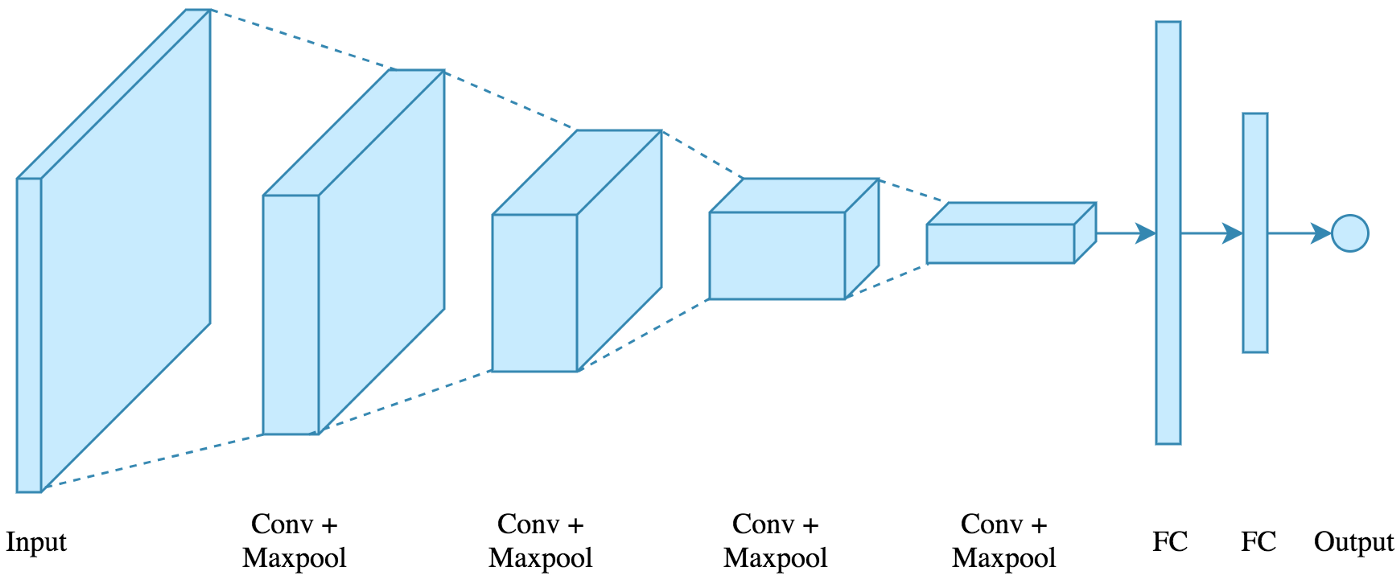

In [15]:
Image(filename = 'CNN_1.png', width = 1000, height = 400)

We'll begin by creating our train, test, and validation datasets in a similar fashion and also standardize the data using MinMaxScaler. 

In [46]:
# Create train, validation and test data 
column_indices = {name: i for i, name in enumerate(Ford.columns)}

n = len(Ford)
X_train = Ford[0:int(n*0.7)]
X_val = Ford[int(n*0.7):int(n*0.9)]
X_test = Ford[int(n*0.9):]

y_train = target_3[0:int(n*0.7)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [47]:
# Standardize the data using MinMaxScaler
X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = Ford.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = Ford.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = Ford.columns)

Here is where the CNN application methods differ from the random forest. In a time-series application of the CNN, it is necessary to create windows for future prediction. Since we are looking to make a prediction about whether a stocks closing price increased or decreased tomorrow relative to today, we will use intervals of data to predict subsequent data. In the code below we create a window of length five. Window length can be picked arbitrarily and is generally tested at varying lengths.

In [48]:
def df_to_X_y2(df, target, window_size=5):
    """
    Generates a a timeseries window to all for prediction of future values. 
    """
    # converts to matrix of numpy arrays  
    df_as_np = df.to_numpy() 

    X = []
    y = []

    # Length of data frame - window_size so it does't take empty values at the end
    for i in range(len(df_as_np)-window_size): 
    
        # Takes row i and all rows above within the window size length
        row = [r for r in df_as_np[i:i+window_size]] 

        # Creates 3 dimentional array (obseravtions, rows in window, features)
        X.append(row)

        # Pulls the target variable after the window, target varible needs to be column zero in this 
        label = target[i+window_size] 

        # returns (N,) martix of targets i+window_length time periods away
        y.append(label) 

    return np.array(X), np.array(y)

In [49]:
def kbest_creator(k):
    """
    Returns list of k best features and the number of efficient principle compents to use with said k features.
    Differs from the kbest_creator function in the random forest section where the only paramter now
    is k.
    """
    # Apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(Ford.columns)
    
    # Concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    # Run PCA decomposition on the K best features
    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 90) # update to 90 and rerun models 
    res = res +1
    res
    
    return feats, res

In [58]:
feats, comp = kbest_creator(10)

sklearn_pca = PCA(n_components=comp)
X_train_1 = pd.DataFrame(sklearn_pca.fit_transform(X_train[feats]))
X_val_1 = pd.DataFrame(sklearn_pca.transform(X_val[feats]))
X_test_1 = pd.DataFrame(sklearn_pca.transform(X_test[feats]))

# converting to window format, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_1,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_1, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_1, y_test)

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Through the use of our window and PCA function, we can see that our train, validation, and test data are now three dimensional arrays. The first dimension corresponds to number of observations, the second is window length, and third is number of features or in this case, principal components.

In [59]:
print(X_train_1.shape, X_val_1.shape, X_test_1.shape)

(491, 5, 4) (137, 5, 4) (66, 5, 4)


In [60]:
# Construct the CNN model
early_stopping_monitor = EarlyStopping(patience=7)

# Window and feature dimensions
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

model1_2 = Sequential()
model1_2.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 
model1_2.add(Conv1D(filters=15, kernel_size=2, activation='relu'))
# better without pooling layer
model1_2.add(Flatten())
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(30, activation='relu')) 
model1_2.add(Dense(1, activation='sigmoid'))

model1_2.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=["accuracy"])

model1_2_hist = model1_2.fit(X_train_1, train_5w,epochs=30,  
                            validation_data=(X_val_1, val_5w), 
                            callbacks = [early_stopping_monitor])

model1_2_hist


Epoch 1/30


c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 1s 9ms/step - loss: 0.6937 - accuracy: 0.5112 - val_loss: 0.6959 - val_accuracy: 0.5255
Epoch 2/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.5418 - val_loss: 0.7000 - val_accuracy: 0.4891
Epoch 3/30
16/16 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5519 - val_loss: 0.7032 - val_accuracy: 0.4818
Epoch 4/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6819 - accuracy: 0.5458 - val_loss: 0.7066 - val_accuracy: 0.4891
Epoch 5/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6781 - accuracy: 0.5662 - val_loss: 0.7135 - val_accuracy: 0.4745
Epoch 6/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5947 - val_loss: 0.7181 - val_accuracy: 0.4453
Epoch 7/30
16/16 [==============================] - 0s 3ms/step - loss: 0.6698 - accuracy: 0.5947 - val_loss: 0.7278 - val_accuracy: 0.4380
Epoch 8/30
16/16 [=============

-----------------------------------------------------------------
train accuracy = 61.0998%
test accuracy = 54.5455%


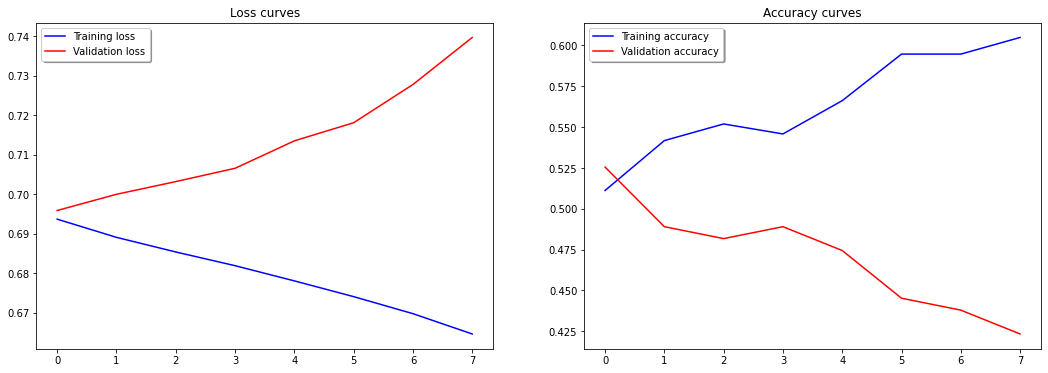

In [61]:
# Predict on test data
y_hat1_2 = model1_2.predict(X_test_1)

# Find the accuracy of the model. Values greater than 0.5 are considered 1, else 0.
y_hat1_2 = y_hat1_2 > .5

# Evaluate the model:
train_loss, train_acc = model1_2.evaluate(X_train_1, train_5w,
                                       batch_size=50, verbose=0)
test_loss, test_acc = model1_2.evaluate(X_test_1, test_5w,
                                     batch_size=50, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')

# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

axs[0].plot(model1_2_hist.history['loss'], color='b', label='Training loss')
axs[0].plot(model1_2_hist.history['val_loss'], color='r', label='Validation loss')

axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(model1_2_hist.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(model1_2_hist.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)

plt.show()

Depicted in the plots above are the loss curves (left) and accuracy curves (right) for our CNN model. Clearly, there is some serious overfitting taking place. Let's try some hyperparamter tuning to see if we can compress the explosive overfitting.

In [225]:
def model_builder_1_1(hp):
    n_steps = X_train_1.shape[1]
    n_features = X_train_1.shape[2]

    model1_2 = Sequential()

    hp_filters = hp.Int('units', min_value=4, max_value=128, step=4)
    hp_units = hp.Int('units', min_value=5, max_value=100, step=10)
    model1_2.add(Conv1D(filters=hp_filters, kernel_size=2, activation='relu', input_shape=(n_steps,n_features))) 

    model1_2.add(Flatten())
    model1_2.add(Dense(units = hp_units, activation='relu')) 
    model1_2.add(Dense(1, activation='sigmoid'))

    model1_2.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=["BinaryAccuracy"])

    return model1_2

tuner = kt.Hyperband(model_builder_1_1,
                     objective='val_binary_accuracy',
                     max_epochs=30,
                     factor=3,
                     # directory='my_dir',    don't know what to do with this for now
                     # project_name='intro_to_kt' # sasme with this
                     )

tuner.search(X_train_1, train_5w, epochs=50, validation_data=(X_val_1, val_5w), callbacks = [early_stopping_monitor])

#model1_1.fit(X_train_kb_10, train_5w,epochs=30,  validation_data=(X_val_kb_10, val_5w), callbacks = [early_stopping_monitor])

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
124               |?                 |units
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
3                 |?                 |tuner/bracket
0                 |?                 |tuner/round

INFO:tensorflow:Assets written to: ram://257d51c8-aa5a-46a9-afff-ec4b6ecc6974/assets


ValueError: All callbacks used during a search should be deep-copyable (since they are reused across trials). It is not possible to do `copy.deepcopy([<keras.callbacks.EarlyStopping object at 0x000002965B674250>])`

Add CNN results for Netflix and UBS and concluding remarks

#### 4.3 Recurrent Neural Network

Our last algorithm we will test is the recurrent neural network (RNN). Considered highly suitable for a time-series tasks such as predicting stock movements, the RNN is favored amongst many machine learning practicioners as the network which will perform best when using sequential data. What makes the RNN useful for timeseries is it's recurrent structure. Essenitally, this is the notion that previous information informs future predictions. The image below helps clarify recurrent action. Unlike most neural networks which presume that the inputs and outputs are independent, in the RNN space, outputs depends on prior elements in the network. Another aspect of RNN's which make them unique is that they share parameters across each layer. In more traditional feedforward networks, each node may have a different weight, however, in RNN networks each layer has the same weight parameter.  

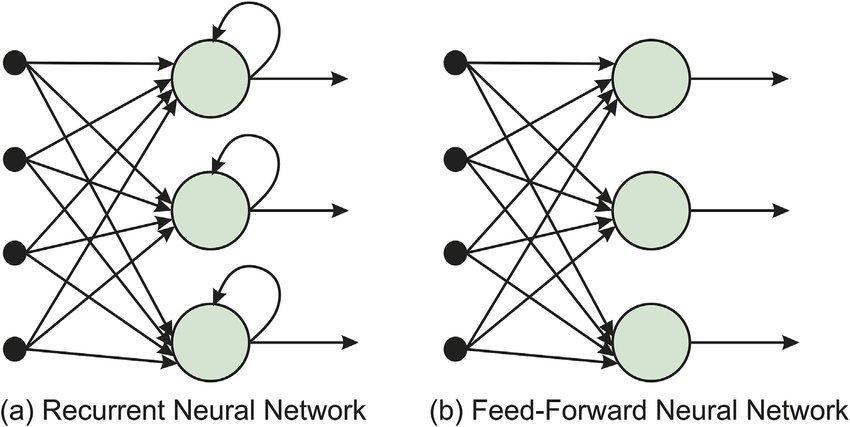

In [112]:
Image(filename='RNN.png', width=700, height=300)   

Intuitively, the RNN models should out perform the random forest and CNN. Let's put that intuition to the test.

In [62]:
# Split data into training, validation and test sets 
column_indices = {name: i for i, name in enumerate(Ford.columns)}

n = len(Ford)
X_train = Ford[0:int(n*0.9)]
X_val = Ford[int(n*0.7):int(n*0.9)]
X_test = Ford[int(n*0.9):]

y_train = target_3[0:int(n*0.9)]
y_val = target_3[int(n*0.7):int(n*0.9)]
y_test = target_3[int(n*0.9):]

In [63]:
# Normalize the data
X_train = pd.DataFrame(Mscaler.fit_transform(X_train), columns = Ford.columns)
X_val = pd.DataFrame(Mscaler.fit_transform(X_val), columns = Ford.columns)
X_test = pd.DataFrame(Mscaler.fit_transform(X_test), columns = Ford.columns)

In [64]:
def kbest_creator(k):
    """
    returns list of k best features and the number of efficient principle compents to use with said k features
    """
    # apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=k)
    best_fit = bestfeatures.fit(X_train, y_train)
    best_scores = pd.DataFrame(best_fit.scores_)
    best_columns = pd.DataFrame(Ford.columns)
    
    # concatenate the dataframes for better visualization
    features_score = pd.concat([best_columns, best_scores], axis=1)
    features_score.columns = ['Features', 'Score']  # naming the dataframe columns
    feats = list(features_score.nlargest(k, 'Score')['Features'])

    pca = PCA().fit(X_train[feats])
    pca_scores = np.cumsum(pca.explained_variance_ratio_) * 100
    res = next(x for x, val in enumerate(pca_scores) if val > 90) 
    res = res +1
    res
    
    return feats, res


Let's try an initial model that includes a PCA on 40 features from SelectKBest

In [65]:
# Pull the top 40 features from the data
feats, pcs = kbest_creator(40)

pca_kb = PCA(n_components = pcs)
X_train_kb = pd.DataFrame(pca_kb.fit_transform(X_train[feats]))
X_val_kb = pd.DataFrame(pca_kb.fit_transform(X_val[feats]))
X_test_kb = pd.DataFrame(pca_kb.fit_transform(X_test[feats]))

# Apply window formatting, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 

print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(633, 5, 15) (633,)
(137, 5, 15) (137,)
(66, 5, 15) (66,)


c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


Particular to our RNN structure is the use of Long Short-term memory (LSTM). What LSTM does is includes "cells" in hidden layers which have an input gate, output gate, and forget gate. While this can see a little abstract, the main purpoe of each of these gates is to manage the flow of prior information needed to predict the binary-classification output. 

In [66]:
# Model using the PCA od 40 SelectKBest features 
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [67]:
# Compile Model
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 8)              768       
                                                                 
 batch_normalization (BatchN  (None, 5, 8)             32        
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 5, 8)              544       
                                                                 
 batch_normalization_1 (Batc  (None, 5, 8)             32        
 hNormalization)                                                 
                                                                 
 lstm_2 (LSTM)               (None, 8)                 544       
                                                                 
 batch_normalization_2 (Batc  (None, 8)               

In [68]:
# Fit model 
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)
# Train the model. 
# The dataset is small for NN - let's use test_data for validation

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
13/13 [==============================] - 5s 49ms/step - loss: 2.7722 - accuracy: 0.5245 - val_loss: 2.5897 - val_accuracy: 0.5401
Epoch 2/100
13/13 [==============================] - 0s 13ms/step - loss: 2.5700 - accuracy: 0.5182 - val_loss: 2.4204 - val_accuracy: 0.5109
Epoch 3/100
13/13 [==============================] - 0s 12ms/step - loss: 2.3857 - accuracy: 0.5403 - val_loss: 2.2651 - val_accuracy: 0.5182
Epoch 4/100
13/13 [==============================] - 0s 12ms/step - loss: 2.2223 - accuracy: 0.5292 - val_loss: 2.1234 - val_accuracy: 0.5182
Epoch 5/100
13/13 [==============================] - 0s 12ms/step - loss: 2.0747 - accuracy: 0.5403 - val_loss: 1.9939 - val_accuracy: 0.5182
Epoch 6/100
13/13 [==============================] - 0s 13ms/step - loss: 1.9494 - accuracy: 0.5340 - val_loss: 1.8756 - val_accuracy: 0.5182
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 1.8274 - accuracy: 0.5450 - val_loss: 1.7678 - val_accuracy: 0.5182
Epoch 

In [69]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 69.5103%
test accuracy = 42.4242%
test error = 38 out of 66 examples


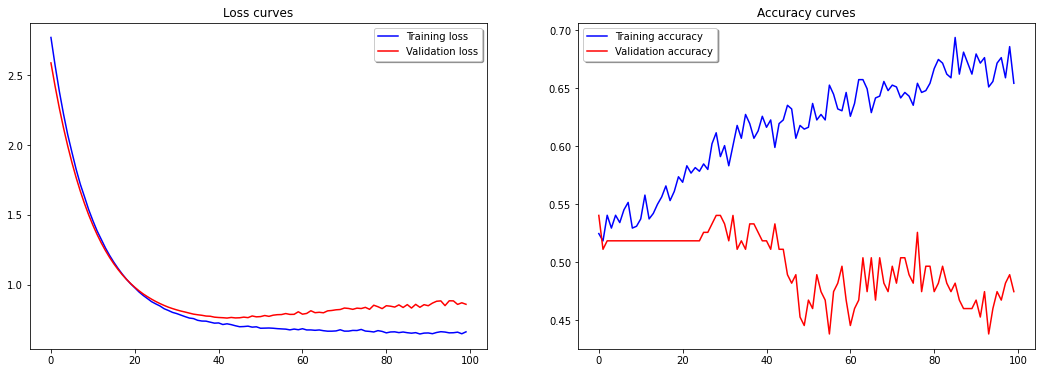

In [70]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

On the left plot we can see that the training and validation losses are decreasing at a similar rate up until 20 epochs. After that point, the two losses begin to diverge. As for the accuracy, we too see some remanence of overfitting.

In [71]:
# Display the predictioned vs actuals 
y_hat = model.predict(X_test_1, batch_size=50, verbose=1)
#score = sum(y_hat == y_test) / len(y_test)
#print(f'Prediction accuracy = {score*100}%')
index = pd.date_range(start='2017-01-02', end='2018-06-19', freq='B')
for i in range(y_hat.shape[0]):
    print(index[i], y_hat[i], test_5w[i])

2/2 [==============================] - 0s 4ms/step
2017-01-02 00:00:00 [0.6865604] 1
2017-01-03 00:00:00 [0.639876] 0
2017-01-04 00:00:00 [0.6816402] 0
2017-01-05 00:00:00 [0.6609611] 0
2017-01-06 00:00:00 [0.21725255] 1
2017-01-09 00:00:00 [0.17877564] 1
2017-01-10 00:00:00 [0.16798061] 0
2017-01-11 00:00:00 [0.1921477] 1
2017-01-12 00:00:00 [0.56922513] 0
2017-01-13 00:00:00 [0.80338144] 0
2017-01-16 00:00:00 [0.48132968] 1
2017-01-17 00:00:00 [0.06511685] 1
2017-01-18 00:00:00 [0.04190415] 1
2017-01-19 00:00:00 [0.08338708] 1
2017-01-20 00:00:00 [0.1204603] 0
2017-01-23 00:00:00 [0.12527317] 0
2017-01-24 00:00:00 [0.21460125] 0
2017-01-25 00:00:00 [0.1088517] 0
2017-01-26 00:00:00 [0.09195241] 0
2017-01-27 00:00:00 [0.5845113] 0
2017-01-30 00:00:00 [0.9602277] 0
2017-01-31 00:00:00 [0.98567873] 0
2017-02-01 00:00:00 [0.98968846] 1
2017-02-02 00:00:00 [0.9606782] 1
2017-02-03 00:00:00 [0.4154551] 1
2017-02-06 00:00:00 [0.5186729] 0
2017-02-07 00:00:00 [0.6312216] 0
2017-02-08 00:00:0

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

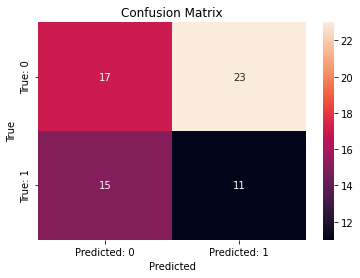

In [72]:
# Display confusion matrix results
from sklearn.metrics import confusion_matrix

ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])


From the confusion matrix we notice that the model is having difficulty predicting negative stock movement (True: 0). Most of the inaccuracy is coming from instances where the model is predicting a positive movement on a true negative movement. This result would lead to some frusterated investors. 

Perhaps selecting 40 features to PCA decompose was too many. Let's see what happens to the accuracy when we decrease the amount of SelectKBest features. 

In [91]:
feats, pcs = kbest_creator(20)

pca_kb = PCA(n_components = pcs)
X_train_kb = pd.DataFrame(pca_kb.fit_transform(X_train[feats]))
X_val_kb = pd.DataFrame(pca_kb.fit_transform(X_val[feats]))
X_test_kb = pd.DataFrame(pca_kb.fit_transform(X_test[feats]))

# Apply window formatting, in this case 5 periods
X_train_1, train_5w = df_to_X_y2(X_train_kb,y_train)
X_val_1, val_5w = df_to_X_y2(X_val_kb, y_val)
X_test_1, test_5w = df_to_X_y2(X_test_kb,y_test) 

print(X_train_1.shape, train_5w.shape)
print(X_val_1.shape, val_5w.shape)
print(X_test_1.shape, test_5w.shape)

(633, 5, 8) (633,)
(137, 5, 8) (137,)
(66, 5, 8) (66,)


c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [92]:
# Same model structure as inital model 
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [8, 8, 8, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()
model.add(LSTM(input_shape=(n_steps, n_features), units=LAYERS[0],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[1],
               activation='tanh', recurrent_activation='hard_sigmoid', 
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=True, return_state=False,
               stateful=False, unroll=False
              ))
model.add(BatchNormalization())
model.add(LSTM(units=LAYERS[2],
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [93]:
# Compile Model
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 5, 8)              544       
                                                                 
 batch_normalization_10 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_11 (LSTM)              (None, 5, 8)              544       
                                                                 
 batch_normalization_11 (Bat  (None, 5, 8)             32        
 chNormalization)                                                
                                                                 
 lstm_12 (LSTM)              (None, 8)                 544       
                                                                 
 batch_normalization_12 (Bat  (None, 8)               

In [94]:
# Fit model 
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=0, 
                             factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_acc', min_delta=0, 
                           patience=30, verbose=1, mode='auto',
                           baseline=0, restore_best_weights=True)

history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    batch_size=50,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
13/13 [==============================] - 5s 49ms/step - loss: 2.7408 - accuracy: 0.5403 - val_loss: 2.4589 - val_accuracy: 0.4964
Epoch 2/100
13/13 [==============================] - 0s 12ms/step - loss: 2.4737 - accuracy: 0.5608 - val_loss: 2.3261 - val_accuracy: 0.5109
Epoch 3/100
13/13 [==============================] - 0s 11ms/step - loss: 2.2988 - accuracy: 0.5545 - val_loss: 2.2001 - val_accuracy: 0.5182
Epoch 4/100
13/13 [==============================] - 0s 10ms/step - loss: 2.1606 - accuracy: 0.5545 - val_loss: 2.0828 - val_accuracy: 0.5182
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 2.0298 - accuracy: 0.5735 - val_loss: 1.9745 - val_accuracy: 0.5182
Epoch 6/100
13/13 [==============================] - 0s 12ms/step - loss: 1.9244 - accuracy: 0.5656 - val_loss: 1.8749 - val_accuracy: 0.5182
Epoch 7/100
13/13 [==============================] - 0s 12ms/step - loss: 1.8224 - accuracy: 0.5608 - val_loss: 1.7833 - val_accuracy: 0.5182
Epoch 

In [95]:
# Evaluate the model:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 67.7725%
test accuracy = 48.4848%
test error = 34 out of 66 examples


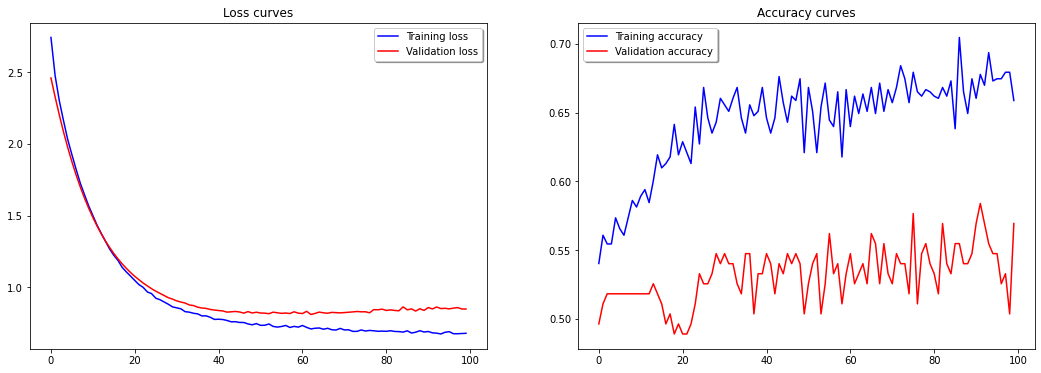

In [96]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Relative to the inital RNN model, the one directly above appears to be slighly more accruacte, and experiencing less overfitting. This seems to be a function of the number of features included in the PCA decomposition. Perhaps we were a little overzelous with our model structure, lets see what happens when we simplify and reduce the amount of hidden layers. 

In [97]:
n_steps = X_train_1.shape[1]
n_features = X_train_1.shape[2]

# Let's make a list of CONSTANTS for modelling:
LAYERS = [32, 32, 32, 1]                # number of units in hidden and output layers
M_TRAIN = X_train_1.shape[0]           # number of training examples (2D)
M_TEST = X_test_1.shape[0]             # number of test examples (2D),full=X_test.shape[0]
N = X_train_1.shape[2]                 # number of features
BATCH = M_TRAIN                          # batch size
EPOCH = 10                           # number of epochs
LR = 5e-2                            # learning rate of the gradient descent
LAMBD = 3e-2                         # lambda in L2 regularizaion
DP = 0.0                             # dropout rate
RDP = 0.0                            # recurrent dropout rate

# Build the Model
model = Sequential()

model.add(LSTM(units=LAYERS[2], input_shape=(n_steps, n_features),
               activation='tanh', recurrent_activation='hard_sigmoid',
               kernel_regularizer=l2(LAMBD), recurrent_regularizer=l2(LAMBD),
               dropout=DP, recurrent_dropout=RDP,
               return_sequences=False, return_state=False,
               stateful=False, unroll=False
              ))

model.add(BatchNormalization())
model.add(Dense(units=LAYERS[3], activation='sigmoid'))

In [98]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'],
              optimizer="adam")
              
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 32)                5248      
                                                                 
 batch_normalization_13 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,409
Trainable params: 5,345
Non-trainable params: 64
_________________________________________________________________
None


In [99]:
history = model.fit(X_train_1, train_5w,
                    epochs=100,
                    validation_data=(X_val_1, val_5w))

Epoch 1/100
20/20 [==============================] - 2s 16ms/step - loss: 2.0622 - accuracy: 0.4566 - val_loss: 1.7598 - val_accuracy: 0.4818
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.6498 - accuracy: 0.4897 - val_loss: 1.4923 - val_accuracy: 0.4599
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 1.3947 - accuracy: 0.5308 - val_loss: 1.2948 - val_accuracy: 0.4672
Epoch 4/100
20/20 [==============================] - 0s 5ms/step - loss: 1.2200 - accuracy: 0.5592 - val_loss: 1.1510 - val_accuracy: 0.5401
Epoch 5/100
20/20 [==============================] - 0s 6ms/step - loss: 1.0908 - accuracy: 0.5624 - val_loss: 1.0460 - val_accuracy: 0.5401
Epoch 6/100
20/20 [==============================] - 0s 5ms/step - loss: 1.0005 - accuracy: 0.5403 - val_loss: 0.9682 - val_accuracy: 0.4891
Epoch 7/100
20/20 [==============================] - 0s 6ms/step - loss: 0.9296 - accuracy: 0.5671 - val_loss: 0.9116 - val_accuracy: 0.5109
Epoch 8/100


In [103]:
train_loss, train_acc = model.evaluate(X_train_1, train_5w,
                                       batch_size=M_TRAIN, verbose=0)
test_loss, test_acc = model.evaluate(X_test_1, test_5w,
                                     batch_size=M_TEST, verbose=0)
print('-'*65)
print(f'train accuracy = {round(train_acc * 100, 4)}%')
print(f'test accuracy = {round(test_acc * 100, 4)}%')
print(f'test error = {round((1 - test_acc) * M_TEST)} out of {M_TEST} examples')

-----------------------------------------------------------------
train accuracy = 55.6082%
test accuracy = 51.5152%
test error = 32 out of 66 examples


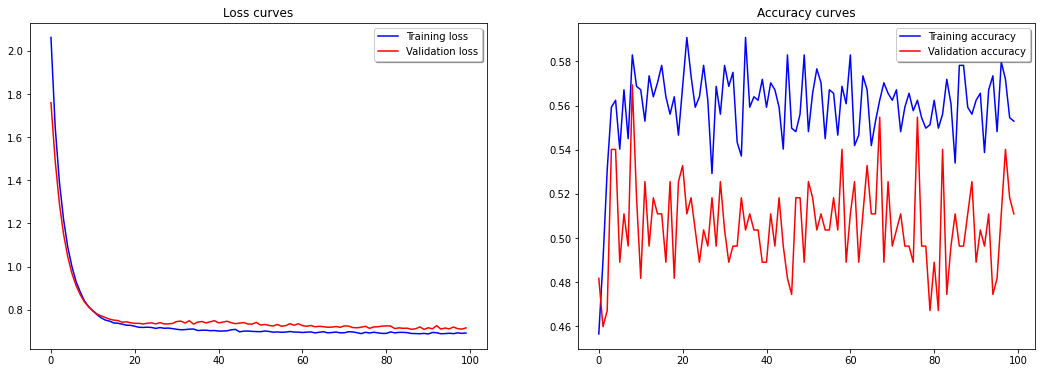

In [104]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

Above are the results for the most simplistic model which included fewer hidden layers and fewer SelectKBest features. While there isn's a significantly large increase in accuracy relative to the prior models, we're pleased to see that overfitting has diminished. Additionally, it's reassuring that the validation loss is not increasing after 40 epochs.  

[Text(0, 0.5, 'True: 0'), Text(0, 1.5, 'True: 1')]

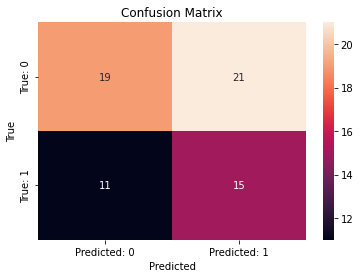

In [101]:
# Display confusion matrix results
ax = plt.subplot()
predicted = model.predict(X_test_1)
predicted = (predicted > 0.5)

confusion = confusion_matrix(test_5w, predicted)

sns.heatmap(confusion, annot=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(["Predicted: 0", "Predicted: 1"])
ax.yaxis.set_ticklabels(["True: 0", "True: 1"])

Provide UBS and Netflix results 

### 5. Discussion of Findings 

With the goal of this project to set out and predict the next day movement of Ford, Netflix, and UBS stock, I think we can say that we achiveved some success, while not enough to make investors lick thier chops. Through the development and testing of random forests, CNN's, and RNN's, we found that the random forest estimator with 26 SelectKBest features provide us with the highest out right accuracy (with respect to Ford). Right behind the random forest was the simple RNN, whicH proved that we were able to develop a model that could predict with greater than 50% accuracy, and not overfit the data. In general, the models presented rarely exceeded 60% accuracy. This could be a function of many factors. One worth noting however, is the data. Pulling data from 01/01/2019 to 03/30/22 was risky. As we all know, this span was a particularly turbluent time and perhaps inflated the non-stationarity of the data. One way to test the hypothesis that the timeframe we chose is supressing our models accuracy would be to measure against another three year window where the market was subject to less severe exogenous shocks.    

While the main goal was to predict next day stock movements, an additional piece of the puzzle was to see the affects Google News and Wikipedia data have on prediction accuracy. In order to see how impactful the inclusion of this news data is, it would be interesting to develop similar models, but exclude the news features from our PCA decompostions. By running the new vs news-less models side-by-side we could resonably estimate the impact news data has on model accuracy. 

In sum, the models developed during this project could certinaly use work. However, if you were to ask a financial advisor today if they would take a 50% shot at getting tomorrow's stock movements correct, my prior suggests that they would say absolutely. 

Fab/Jack - Feel free to build this out and include any other suggestions/thoughts about what would be improved upon or what is causing our models to not get >50% accuracy. Enjoy your summer boys. Cheers!

### 6. References 